In [1]:
# %% Import modules
from numpy.core.fromnumeric import repeat
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, execute, Aer
from qiskit.visualization import plot_histogram
from IPython.display import display

from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer.extensions.snapshot_statevector import *

# Import our own files
#from custom_noise_models import pauli_noise_model
#from custom_transpiler import shortest_transpile_from_distribution, WAQCT_device_properties

# Transpiler
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager, CouplingMap, Layout
from qiskit.visualization import plot_circuit_layout
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.circuit.library.standard_gates import iSwapGate, SwapGate, SGate, CZGate
from qiskit import QuantumCircuit, QuantumRegister
import warnings

In [2]:
# %% Defining useful functions

# Not that this does not consider our setup
def logical_states():
    logical_0 = np.zeros(2**5)
    logical_0[0b00000] = 1/4
    logical_0[0b10010] = 1/4
    logical_0[0b01001] = 1/4
    logical_0[0b10100] = 1/4
    logical_0[0b01010] = 1/4
    logical_0[0b11011] = -1/4
    logical_0[0b00110] = -1/4
    logical_0[0b11000] = -1/4
    logical_0[0b11101] = -1/4
    logical_0[0b00011] = -1/4
    logical_0[0b11110] = -1/4
    logical_0[0b01111] = -1/4
    logical_0[0b10001] = -1/4
    logical_0[0b01100] = -1/4
    logical_0[0b10111] = -1/4
    logical_0[0b00101] = 1/4

    logical_1 = np.zeros(2**5)
    logical_1[0b11111] = 1/4
    logical_1[0b01101] = 1/4
    logical_1[0b10110] = 1/4
    logical_1[0b01011] = 1/4
    logical_1[0b10101] = 1/4
    logical_1[0b00100] = -1/4
    logical_1[0b11001] = -1/4
    logical_1[0b00111] = -1/4
    logical_1[0b00010] = -1/4
    logical_1[0b11100] = -1/4
    logical_1[0b00001] = -1/4
    logical_1[0b10000] = -1/4
    logical_1[0b01110] = -1/4
    logical_1[0b10011] = -1/4
    logical_1[0b01000] = -1/4
    logical_1[0b11010] = 1/4

    # Add two ancillas in |0>
    an0 = np.zeros(2**2)
    an0[0] = 1.0

    logical_1 = np.kron(logical_1, an0)
    logical_0 = np.kron(logical_0, an0)

    #logical_0 = np.kron(an0, logical_0)
    #logical_1 = np.kron(an0, logical_1)
    return [logical_0, logical_1]

def encode_input(qbReg):
    '''Encode the input into logical 0 and 1
    This assumes that the 0:th qubit is the
    original state |psi> = a|0> + b|1>'''
    encoding_circuit = QuantumCircuit(qbReg)

    encoding_circuit.h(qbReg[3])
    encoding_circuit.cz(qbReg[3], qbReg[1])
    encoding_circuit.cz(qbReg[3], qbReg[2])
    encoding_circuit.cx(qbReg[3], qbReg[0])

    encoding_circuit.h(qbReg[2])
    encoding_circuit.cx(qbReg[2], qbReg[0])
    encoding_circuit.cz(qbReg[2], qbReg[3])
    encoding_circuit.cz(qbReg[2], qbReg[4])

    encoding_circuit.h(qbReg[1])
    encoding_circuit.cz(qbReg[1], qbReg[0])
    encoding_circuit.cx(qbReg[1], qbReg[3])
    encoding_circuit.cz(qbReg[1], qbReg[4])

    encoding_circuit.h(qbReg[4])
    encoding_circuit.cz(qbReg[4], qbReg[2])
    encoding_circuit.cz(qbReg[4], qbReg[3])
    encoding_circuit.cx(qbReg[4], qbReg[1])

    return encoding_circuit


def measure_stabilizer(qbReg, anReg, clReg, i, reset=True):
    '''Function for adding stabilizer measurements to a circuit.
    Note that a measurement of X is done by using Hadamard before
    and after. Input i specifies the stabilizer to measure:
        i=0: XZZXI
        i=1: IXZZX
        i=2: XIXZZ
        i=3: ZXIXZ
    Other inputs are the circuit as well as the required registers'''

    if not isinstance(i, int):
        raise error('i must be an integer')

    stab_circuit = QuantumCircuit(qbReg, anReg, clReg)#, flagReg)

    # Generate indexes
    index = np.mod(i + np.array([0, 1, 2, 3]), 5)


    
    if i == 0:

        

        # X
        stab_circuit.h(qbReg[index[0]]) # X
        stab_circuit.h(anReg[1])
        stab_circuit.cz(anReg[1], qbReg[index[0]])
        stab_circuit.h(qbReg[index[0]])

        # Test error
        #stab_circuit.x(anReg[1]) 
        #stab_circuit.z(anReg[1]) 

        # Flag
 #       stab_circuit.h( anReg[0] ) # Initialize in +
 #       stab_circuit.cz( anReg[0], anReg[1] ) # Flag CX

        # ADDED ERROR
        #stab_circuit.x(anReg[1])

        # Z
        stab_circuit.cz(anReg[1], qbReg[index[1]])

        
        # Z
        stab_circuit.cz(anReg[1], qbReg[index[2]])

        


        # Flag
#        stab_circuit.cz( anReg[0], anReg[1] )

        

        # X
        stab_circuit.h(qbReg[index[3]])
        stab_circuit.cz(anReg[1], qbReg[index[3]])
        stab_circuit.h(anReg[1])
        stab_circuit.h(qbReg[index[3]])

        

        # Measure
        stab_circuit.measure(anReg[1], clReg[i])
#        stab_circuit.h(anReg[0])
#        stab_circuit.measure(anReg[0], flagReg[i])
        if reset:
            stab_circuit.reset(anReg[1])
#            stab_circuit.reset(anReg[0])

    else:
        # Measure stabilizers
        stab_circuit.h(qbReg[index[0]])
        stab_circuit.h(anReg[1])
        stab_circuit.cz(anReg[1], qbReg[index[0]])
        stab_circuit.h(qbReg[index[0]])

        stab_circuit.cz(anReg[1], qbReg[index[1]])

        stab_circuit.cz(anReg[1], qbReg[index[2]])

        stab_circuit.h(qbReg[index[3]])
        stab_circuit.cz(anReg[1], qbReg[index[3]])
        stab_circuit.h(anReg[1])
        stab_circuit.h(qbReg[index[3]])


        stab_circuit.measure(anReg[1], clReg[i])
        if reset:
            stab_circuit.reset(anReg[1])

    return stab_circuit


def run_stabilizer(qbReg, anReg, clReg, flagReg, reset=True):
    stab_circuit = QuantumCircuit(qbReg, anReg, clReg, flagReg)
    stab_circuit += measure_stabilizer(qbReg, anReg, clReg, flagReg, 0, reset)
    stab_circuit += measure_stabilizer(qbReg, anReg, clReg, flagReg, 1, reset)
    stab_circuit += measure_stabilizer(qbReg, anReg, clReg, flagReg, 2, reset)
    stab_circuit += measure_stabilizer(qbReg, anReg, clReg, flagReg, 3, reset)
    return stab_circuit


# Correct possible errors
def recovery_scheme(qbReg, clReg, reset=True):

    recovery_circuit = QuantumCircuit(qbReg, clReg)

    # If the ancilla is reset to |0> between measurements
    if reset:
        recovery_circuit.x(qbReg[1]).c_if(clReg, 1)
        recovery_circuit.z(qbReg[4]).c_if(clReg, 2)
        recovery_circuit.x(qbReg[2]).c_if(clReg, 3)
        recovery_circuit.z(qbReg[2]).c_if(clReg, 4)
        recovery_circuit.z(qbReg[0]).c_if(clReg, 5)
        recovery_circuit.x(qbReg[3]).c_if(clReg, 6)
        recovery_circuit.x(qbReg[2]).c_if(clReg, 7)
        recovery_circuit.z(qbReg[2]).c_if(clReg, 7)
        recovery_circuit.x(qbReg[0]).c_if(clReg, 8)
        recovery_circuit.z(qbReg[3]).c_if(clReg, 9)
        recovery_circuit.z(qbReg[1]).c_if(clReg, 10)
        recovery_circuit.x(qbReg[1]).c_if(clReg, 11)
        recovery_circuit.z(qbReg[1]).c_if(clReg, 11)
        recovery_circuit.x(qbReg[4]).c_if(clReg, 12)
        recovery_circuit.x(qbReg[0]).c_if(clReg, 13)
        recovery_circuit.z(qbReg[0]).c_if(clReg, 13)
        recovery_circuit.x(qbReg[4]).c_if(clReg, 14)
        recovery_circuit.z(qbReg[4]).c_if(clReg, 14)
        recovery_circuit.x(qbReg[3]).c_if(clReg, 15)
        recovery_circuit.z(qbReg[3]).c_if(clReg, 15)

    # If the ancilla is NOT reset between measurements
    else:
        recovery_circuit.x(qbReg[2]).c_if(clReg, 1)
        recovery_circuit.x(qbReg[3]).c_if(clReg, 2)
        recovery_circuit.z(qbReg[0]).c_if(clReg, 3)
        recovery_circuit.x(qbReg[4]).c_if(clReg, 4)
        recovery_circuit.z(qbReg[3]).c_if(clReg, 5)
        recovery_circuit.x(qbReg[3]).c_if(clReg, 5)
        recovery_circuit.z(qbReg[1]).c_if(clReg, 6)
        recovery_circuit.z(qbReg[3]).c_if(clReg, 7)
        recovery_circuit.x(qbReg[0]).c_if(clReg, 8)
        recovery_circuit.z(qbReg[1]).c_if(clReg, 9)
        recovery_circuit.x(qbReg[1]).c_if(clReg, 9)
        recovery_circuit.z(qbReg[4]).c_if(clReg, 10)
        recovery_circuit.x(qbReg[4]).c_if(clReg, 10)
        recovery_circuit.z(qbReg[0]).c_if(clReg, 11)
        recovery_circuit.x(qbReg[0]).c_if(clReg, 11)
        recovery_circuit.z(qbReg[2]).c_if(clReg, 12)
        recovery_circuit.z(qbReg[2]).c_if(clReg, 13)
        recovery_circuit.x(qbReg[2]).c_if(clReg, 13)
        recovery_circuit.z(qbReg[4]).c_if(clReg, 14)
        recovery_circuit.x(qbReg[1]).c_if(clReg, 15)

    return recovery_circuit


In [4]:
# %% Running the quantum circuit

def define_circuit(n_cycles):
    '''Creates the entire circuit and returns it
    as an output. Input is the number of stabilizer
    cycles to perform'''
    # Define our registers
    # The 5 qubits to encode the state in
    qb = QuantumRegister(5, 'code_qubit')
    # The two ancilla qubits (one of them is unused)
    an = QuantumRegister(2, 'ancilla_qubit')
    cr = ClassicalRegister(5, 'syndrome_bit')
    # Flags
    flag = ClassicalRegister(1, 'flag_bit')
    # Readout of the final state at the end for statistics
    readout = ClassicalRegister(5, 'readout')

    circuit = QuantumCircuit(cr, readout, an, qb) #, flag,

    # Prepare the input
    circuit.x(qb[0])  # As an example, start in |1>

    # Encode the state
    circuit += encode_input(qb)
    circuit.snapshot_statevector('post_encoding')

    # Random error
    #circuit.z( qb[0] )
    #circuit.x( qb[3] )

    # Stabilizers
    for i in range(n_cycles):
        circuit += new_stabilizer( qb, an, cr, reset=True )# flag,
    #    circuit += run_stabilizer(qb, an, cr, flag, reset=True)
    #    circuit += recovery_scheme(qb, cr, reset=True)
        circuit.snapshot_statevector('stabilizer')

    # Readout of the encoded state
    # Measure at the end of the run
    circuit.measure(qb, readout)
    circuit.snapshot_statevector('post_measure')

    return circuit




In [3]:
# New Stabilizer
def new_stabilizer(qbReg, anReg, clReg, reset=True):#, flagReg
    
    circ = QuantumCircuit(qbReg, anReg, clReg)#, flagReg)

    ## ===Step 1: Run XZZXI with flag===

    # X
    circ.h( qbReg[0] ) # X
    circ.h( anReg[1] )
    circ.cz( anReg[1], qbReg[0] )
    circ.h( qbReg[0] )
    

    # Flag
    circ.h( anReg[0] ) # Initialize in +
    circ.cz( anReg[0], anReg[1] ) # Flag CX        

    # Z
    circ.cz(anReg[1], qbReg[1])
    
    # Z
    circ.cz( anReg[1], qbReg[2] )

    # Flag
    circ.cz( anReg[0], anReg[1] )   

    # X
    circ.h(qbReg[3])
    circ.cz(anReg[1], qbReg[3])
    circ.h(anReg[1])
    circ.h(qbReg[3])

    # Measure
    circ.measure(anReg[1], clReg[0])
    circ.h(anReg[0])
    circ.measure(anReg[0], clReg[4])
    if reset:
        circ.reset(anReg[1])
        circ.reset(anReg[0])
    
    # Run the stabilizers
    circ += measure_stabilizer(qbReg, anReg, clReg, 0, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 1, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 2, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 3, reset=True)#, flagReg

    # Temporary recovery
    circ.y(qbReg[2]).c_if(clReg, 1+16)
    circ.x(qbReg[3]).c_if(clReg, 1+16)
    circ.z(qbReg[2]).c_if(clReg, 2+16)
    circ.x(qbReg[3]).c_if(clReg, 2+16)
    circ.x(qbReg[1]).c_if(clReg, 3+16)
    circ.z(qbReg[2]).c_if(clReg, 3+16)
    circ.x(qbReg[3]).c_if(clReg, 3+16)
    circ.x(qbReg[2]).c_if(clReg, 5+16)
    circ.x(qbReg[3]).c_if(clReg, 5+16)
    circ.x(qbReg[3]).c_if(clReg, 6+16)
    circ.x(qbReg[0]).c_if(clReg, 8+16) # This seems equivalent with IZZXI
    circ.y(qbReg[1]).c_if(clReg, 9+16)
    circ.z(qbReg[2]).c_if(clReg, 9+16)
    circ.x(qbReg[3]).c_if(clReg, 9+16)

    ## ===Step 2: Run IXZZX with flag===

    # X
    circ.h( qbReg[1] ) # X
    circ.h( anReg[1] )
    circ.cz( anReg[1], qbReg[1] )
    circ.h( qbReg[1] )

    # Flag
    circ.h( anReg[0] ) # Initialize in +
    circ.cz( anReg[0], anReg[1] ) # Flag CX        

    # Z
    circ.cz( anReg[1], qbReg[2] )

    # Z
    circ.cz( anReg[1], qbReg[3] )

    # Flag
    circ.cz( anReg[0], anReg[1] )   

    # X
    circ.h(qbReg[4])
    circ.cz(anReg[1], qbReg[4])
    circ.h(anReg[1])
    circ.h(qbReg[4])

    # Measure
    circ.measure(anReg[1], clReg[1])
    circ.h(anReg[0])
    circ.measure(anReg[0], clReg[4])
    if reset:
        circ.reset(anReg[1])
        circ.reset(anReg[0])
    
    # Run the stabilizers
    circ += measure_stabilizer(qbReg, anReg, clReg, 0, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 1, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 2, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 3, reset=True)#, flagReg

    # Temporary recovery 2
    circ.x( qbReg[1] ).c_if( clReg, 1+16 )
    circ.x( qbReg[1] ).c_if( clReg, 2+16 )
    circ.x( qbReg[2] ).c_if( clReg, 2+16 )
    circ.y( qbReg[3] ).c_if( clReg, 3+16 )
    circ.x( qbReg[4] ).c_if( clReg, 3+16 )
    circ.z( qbReg[3] ).c_if( clReg, 5+16 )
    circ.x( qbReg[4] ).c_if( clReg, 5+16 )
    circ.x( qbReg[0] ).c_if( clReg, 6+16 )
    circ.y( qbReg[4] ).c_if( clReg, 6+16 )
    circ.x( qbReg[3] ).c_if( clReg,10+16 )
    circ.x( qbReg[4] ).c_if( clReg,10+16 )
    circ.x( qbReg[4] ).c_if( clReg,12+16 )

    
    ## ===Step 3: Run XIXZZ with flag===

    # X
    circ.h( qbReg[0] ) # X
    circ.h( anReg[1] )
    circ.cz( anReg[1], qbReg[0] )
    circ.h( qbReg[0] )

    # Flag
    circ.h( anReg[0] ) # Initialize in +
    circ.cz( anReg[0], anReg[1] ) # Flag CX        

    # X
    circ.h( qbReg[2] ) # X
    circ.cz( anReg[1], qbReg[2] )
    circ.h( qbReg[2] )

    # Z
    circ.cz( anReg[1], qbReg[3] )

    # Flag
    circ.cz( anReg[0], anReg[1] )   

    # Z
    circ.cz( anReg[1], qbReg[4] )
    circ.h(anReg[1])

    # Measure
    circ.measure(anReg[1], clReg[2])
    circ.h(anReg[0])
    circ.measure(anReg[0], clReg[4])
    if reset:
        circ.reset(anReg[1])
        circ.reset(anReg[0])
    
    # Run the stabilizers
    circ += measure_stabilizer(qbReg, anReg, clReg, 0, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 1, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 2, reset=True)#, flagReg
    circ += measure_stabilizer(qbReg, anReg, clReg, 3, reset=True)#, flagReg

    # Temporary recovery 3
    circ.x( qbReg[1] ).c_if( clReg, 2+16)
    circ.x( qbReg[2] ).c_if( clReg, 2+16)
    circ.x( qbReg[3] ).c_if( clReg, 4+16)
    circ.z( qbReg[4] ).c_if( clReg, 4+16)

    circ.x( qbReg[0] ).c_if( clReg, 8+16) # Seems equivalent with IZZXI
    circ.x( qbReg[0] ).c_if( clReg, 11+16)
    circ.x( qbReg[2] ).c_if( clReg, 11+16)
    circ.x( qbReg[4] ).c_if( clReg, 12+16)
    circ.z( qbReg[0] ).c_if( clReg, 13+16)
    circ.z( qbReg[2] ).c_if( clReg, 13+16)
    circ.x( qbReg[4] ).c_if( clReg, 13+16)
    circ.x( qbReg[2] ).c_if( clReg, 15+16)
    circ.x( qbReg[4] ).c_if( clReg, 15+16)

    ## ===Step 4: Run ZXIXZ with flag===

    # Z
    circ.h( anReg[1] )
    circ.cz( anReg[1], qbReg[0] )

    # Flag
    circ.h( anReg[0] ) # Initialize in +
    circ.cz( anReg[0], anReg[1] ) # Flag CX  

    # X
    circ.h( qbReg[1] ) # X
    circ.cz( anReg[1], qbReg[1] )
    circ.h( qbReg[1] )

    # X
    circ.h( qbReg[3] ) # X
    circ.cz( anReg[1], qbReg[3] )
    circ.h( qbReg[3] )

    # Flag
    circ.cz( anReg[0], anReg[1] )   
    
    # Z
    circ.cz( anReg[1], qbReg[4] )
    circ.h(anReg[1])

    # Measure
    circ.measure(anReg[1], clReg[3])
    circ.h(anReg[0])
    circ.measure(anReg[0], clReg[4])
    if reset:
        circ.reset(anReg[1])
        circ.reset(anReg[0])
    
    # Run the stabilizers
    circ += measure_stabilizer(qbReg, anReg, clReg, 0, reset=True)
    circ += measure_stabilizer(qbReg, anReg, clReg, 1, reset=True)
    circ += measure_stabilizer(qbReg, anReg, clReg, 2, reset=True)
    circ += measure_stabilizer(qbReg, anReg, clReg, 3, reset=True)

    # Temporary recovery 4
    circ.x( qbReg[1] ).c_if( clReg, 2+16)
    circ.x( qbReg[2] ).c_if( clReg, 2+16)
    circ.x( qbReg[3] ).c_if( clReg, 4+16)
    circ.z( qbReg[4] ).c_if( clReg, 4+16)
    circ.x( qbReg[2] ).c_if( clReg, 5+16 )
    circ.x( qbReg[3] ).c_if( clReg, 5+16 )
    circ.x( qbReg[0] ).c_if( clReg, 11+16)
    circ.x( qbReg[2] ).c_if( clReg, 11+16)
    circ.z( qbReg[0] ).c_if( clReg, 13+16)
    circ.z( qbReg[2] ).c_if( clReg, 13+16)
    circ.x( qbReg[4] ).c_if( clReg, 13+16)
    circ.x( qbReg[0] ).c_if( clReg, 14+16 )
    circ.z( qbReg[2] ).c_if( clReg, 14+16 )
    circ.z( qbReg[4] ).c_if( clReg, 14+16 )
    circ.x( qbReg[2] ).c_if( clReg, 15+16)
    circ.x( qbReg[4] ).c_if( clReg, 15+16)

    return circ



Fidelity:
1.0
Average fidelity:
1.0


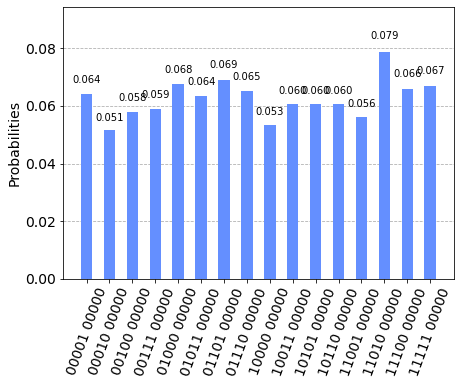

In [5]:
# Create the circuit
n_cycles = 1
circuit = define_circuit( n_cycles )
#transpiled_circuit = transpile_circuit( circuit )
#transpiled_circuit._layout

n_shots = 2000
results = execute(
    circuit,  
    Aer.get_backend('qasm_simulator'),
    noise_model=None,
    shots=n_shots
).result()

# Analyze results
logical = logical_states()
sv_post_encoding = results.data()['snapshots']['statevector']['stabilizer'][0]
print('Fidelity:')
print( state_fidelity(logical[1], sv_post_encoding) )
fid = 0
for i in range(10):
    fid += state_fidelity(logical[1], results.data()['snapshots']['statevector']['stabilizer'][i])

fid /= 10
print('Average fidelity:')
print(fid)
# % Extract data from simulations
counts = results.get_counts()
plot_histogram( counts )
#circuit.draw(output='mpl')


In [295]:
## Further methods of finding the recovery
#print( state_fidelity(sv_post_encoding, logical[1]) )


log1 = logical[1][np.arange(128,step=4)]
sv_test = sv_post_encoding[np.arange(128,step=4)]



test = sv_test.real
tester= np.zeros(32)
for i in range(32):
    tester[i] = round(test[i], 2)
#print(log1)
fid = state_fidelity(sv_test, log1)
#print(tester)


# Define some operators
I = np.eye(2)
X = np.array([[ 0, 1 ],[1 , 0]])
Y = np.array([[ 0,-1j],[1j, 0]])
Z = np.array([[ 1, 0 ],[0 ,-1]])

XIIII = np.kron( X, np.kron( np.kron( np.kron( I, I ), I ), I ) )
IXIII = np.kron( I, np.kron( np.kron( np.kron( X, I ), I ), I ) )
IIXII = np.kron( I, np.kron( np.kron( np.kron( I, X ), I ), I ) )
IIIXI = np.kron( I, np.kron( np.kron( np.kron( I, I ), X ), I ) )
IIIIX = np.kron( I, np.kron( np.kron( np.kron( I, I ), I ), X ) )

ZIIII = np.kron( Z, np.kron( np.kron( np.kron( I, I ), I ), I ) )
IZIII = np.kron( I, np.kron( np.kron( np.kron( Z, I ), I ), I ) )
IIZII = np.kron( I, np.kron( np.kron( np.kron( I, Z ), I ), I ) )
IIIZI = np.kron( I, np.kron( np.kron( np.kron( I, I ), Z ), I ) )
IIIIZ = np.kron( I, np.kron( np.kron( np.kron( I, I ), I ), Z ) )

YIIII = np.kron( Y, np.kron( np.kron( np.kron( I, I ), I ), I ) )
IYIII = np.kron( I, np.kron( np.kron( np.kron( Y, I ), I ), I ) )
IIYII = np.kron( I, np.kron( np.kron( np.kron( I, Y ), I ), I ) )
IIIYI = np.kron( I, np.kron( np.kron( np.kron( I, I ), Y ), I ) )
IIIIY = np.kron( I, np.kron( np.kron( np.kron( I, I ), I ), Y ) )

for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    tempy = tester
                    if i1==1:
                        tempy = XIIII @ tempy
                    elif i1==2:
                        tempy == ZIIII @ tempy
                    elif i1==3:
                        tempy == YIIII @ tempy

                    if i2==1:
                        tempy = IXIII @ tempy
                    elif i2==2:
                        tempy == IZIII @ tempy
                    elif i2==3:
                        tempy == IYIII @ tempy

                    if i3==1:
                        tempy = IIXII @ tempy
                    elif i3==2:
                        tempy == IIZII @ tempy
                    elif i3==3:
                        tempy == IIYII @ tempy

                    if i4==1:
                        tempy = IIIXI @ tempy
                    elif i4==2:
                        tempy == IIIZI @ tempy
                    elif i4==3:
                        tempy == IIIYI @ tempy

                    if i5==1:
                        tempy = IIIIX @ tempy
                    elif i5==2:
                        tempy == IIIIZ @ tempy
                    elif i5==3:
                        tempy == IIIIY @ tempy
                    
                    check_fid = state_fidelity(tempy, log1)
                    if check_fid == 1:
                        print('Success')
                        print(i1,i2,i3,i4,i5)

Success
0 0 1 0 1
Success
0 0 1 2 1
Success
0 0 1 3 1
Success
0 2 1 0 1
Success
0 2 1 2 1
Success
0 2 1 3 1
Success
0 3 1 0 1
Success
0 3 1 2 1
Success
0 3 1 3 1
Success
2 0 1 0 1
Success
2 0 1 2 1
Success
2 0 1 3 1
Success
2 2 1 0 1
Success
2 2 1 2 1
Success
2 2 1 3 1
Success
2 3 1 0 1
Success
2 3 1 2 1
Success
2 3 1 3 1
Success
3 0 1 0 1
Success
3 0 1 2 1
Success
3 0 1 3 1
Success
3 2 1 0 1
Success
3 2 1 2 1
Success
3 2 1 3 1
Success
3 3 1 0 1
Success
3 3 1 2 1
Success
3 3 1 3 1


In [104]:
log1 = logical[1][np.arange(128,step=4)]
log0 = logical[0][np.arange(128,step=4)]
# Define some operators
I = np.eye(2)
X = np.array([[ 0, 1 ],[1 , 0]])
Y = np.array([[ 0,-1j],[1j, 0]])
Z = np.array([[ 1, 0 ],[0 ,-1]])

XIIII = np.kron( X, np.kron( np.kron( np.kron( I, I ), I ), I ) )
IXIII = np.kron( I, np.kron( np.kron( np.kron( X, I ), I ), I ) )
IIXII = np.kron( I, np.kron( np.kron( np.kron( I, X ), I ), I ) )
IIIXI = np.kron( I, np.kron( np.kron( np.kron( I, I ), X ), I ) )
IIIIX = np.kron( I, np.kron( np.kron( np.kron( I, I ), I ), X ) )

ZIIII = np.kron( Z, np.kron( np.kron( np.kron( I, I ), I ), I ) )
IZIII = np.kron( I, np.kron( np.kron( np.kron( Z, I ), I ), I ) )
IIZII = np.kron( I, np.kron( np.kron( np.kron( I, Z ), I ), I ) )
IIIZI = np.kron( I, np.kron( np.kron( np.kron( I, I ), Z ), I ) )
IIIIZ = np.kron( I, np.kron( np.kron( np.kron( I, I ), I ), Z ) )

YIIII = np.kron( Y, np.kron( np.kron( np.kron( I, I ), I ), I ) )
IYIII = np.kron( I, np.kron( np.kron( np.kron( Y, I ), I ), I ) )
IIYII = np.kron( I, np.kron( np.kron( np.kron( I, Y ), I ), I ) )
IIIYI = np.kron( I, np.kron( np.kron( np.kron( I, I ), Y ), I ) )
IIIIY = np.kron( I, np.kron( np.kron( np.kron( I, I ), I ), Y ) )


a = XIIII @ log0
b = IIIXI @ log0
print(state_fidelity(a,b))

0.0
